In [1]:
# Imports

import pandas as pd
import lightkurve as lk

/Users/swebber/pythonvenvs/quantumcomet/lib/python3.10/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
# load in the pandas dataframe
df = pd.read_csv("KeplerObjectsOfInterest.csv", comment="#")

df


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,-128.0,2.992,0.030,-0.027,7.824,0.223,-1.896,296.76288,47.145142,10.998


In [3]:
# kepid for (koi_disposition == CONFIRMED && koi_pdisposition == CANDIDATE) or (koi_disposition == FALSE POSITIVE && koi_pdisposition == FALSE POSITIVE)
# kepid_confirmed = df.loc[(df['koi_disposition'] == "CONFRIMED") & (df['koi_pdisposition'] == 'CANDIDATE'), 'kepid']
kepid_confirmed = df[df['koi_disposition'] == 'CONFIRMED'][df['koi_pdisposition'] == 'CANDIDATE']['kepid']

confirmed_stars_to_planets = {}
for id in kepid_confirmed:
    confirmed_stars_to_planets[id] = df[df['kepid'] == id]['kepler_name'].tolist()

kepid_false_pos = df[df['koi_disposition'] == 'FALSE POSITIVE'][df['koi_pdisposition'] == 'FALSE POSITIVE']['kepid']

fp_stars_to_planets = {}
for id in kepid_false_pos:
    fp_stars_to_planets[id] = df[df['kepid'] == id]['kepler_name'].tolist()



/var/folders/d4/hhnp4w754y1446g43_srytjh0000gn/T/ipykernel_29832/63737405.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kepid_confirmed = df[df['koi_disposition'] == 'CONFIRMED'][df['koi_pdisposition'] == 'CANDIDATE']['kepid']
/var/folders/d4/hhnp4w754y1446g43_srytjh0000gn/T/ipykernel_29832/63737405.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kepid_false_pos = df[df['koi_disposition'] == 'FALSE POSITIVE'][df['koi_pdisposition'] == 'FALSE POSITIVE']['kepid']


In [4]:
for id, planets in confirmed_stars_to_planets.items():
    print(id)
    print(planets)
    break

10797460
['Kepler-227 b', 'Kepler-227 c']


In [5]:
import pickle
import os

# Create directories to store curves
os.makedirs("./confirmed_curves", exist_ok=True)
os.makedirs("./false_positive_curves", exist_ok=True)

In [6]:
confirmed_curves = {} # Maps kepid of confirmed candidates to the corresponding light curve
curve_count = len(confirmed_stars_to_planets)

for i, (id, planets) in enumerate(confirmed_stars_to_planets.items()):

    filepath = f"confirmed_curves/confirmed_{id}.pkl"
    try:
        if not os.path.exists(filepath):
            print(f"Working on {i}/{curve_count}")
            lcf_collection = lk.search_lightcurve(f'KIC {id}', mission='Kepler').download_all()
            lc_stitched = lcf_collection.stitch()

            data_to_save = {
                "planets" : planets,
                "time": lc_stitched.time.value,
                "flux": lc_stitched.flux.value,
                "flux_err": lc_stitched.flux_err.value
            }
            confirmed_curves[id] = data_to_save

            with open(filepath, 'wb') as f:
                pickle.dump(data_to_save, f)
        else:
            print(f"Passing on {i}/{curve_count}")
    except Exception as e:
        print("************************************************************************************")
        print(e)
        print("************************************************************************************")
        continue






Passing on 0/1967
Passing on 1/1967
Passing on 2/1967
Working on 3/1967


************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr010910878_lc_Q011111110111011101/kplr010910878-2013011073258_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Passing on 4/1967
Passing on 5/1967
Passing on 6/1967
Passing on 7/1967
Passing on 8/1967
Passing on 9/1967
Passing on 10/1967
Passing on 11/1967
Passing on 12/1967
Passing on 13/1967
Passing on 14/1967
Passing on 15/1967
Passing on 16/1967
Passing on 17/1967
Passing on 18/1967
Passing on 19/1967
Passing on 20/1967
Passing on 21/1967
Passing on 22/1967
Passing on 23/1967
Passing on 24/1967
Passing on 25/1967
Passing on 26/1967
Passing on 27/1967
Passing on 28/1967
Passing on 29/1967
Passing on 30/1967
Passing on 31/1967
Passing on 32/19

************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr008591693_lc_Q011111111111111111/kplr008591693-2010174085026_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Passing on 813/1967
Passing on 814/1967
Passing on 815/1967
Passing on 816/1967
Passing on 817/1967
Passing on 818/1967
Passing on 819/1967
Passing on 820/1967
Passing on 821/1967
Passing on 822/1967
Passing on 823/1967
Passing on 824/1967
Passing on 825/1967
Passing on 826/1967
Passing on 827/1967
Passing on 828/1967
Passing on 829/1967
Passing on 830/1967
Passing on 831/1967
Passing on 832/1967
Passing on 833/1967
Passing on 834/1967
Passing on 835/1967
Passing on 836/1967
Passing on 837/1967
Passing on 838/1967
Passing on 839/1967
Pa

************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr010328458_lc_Q011111111111111111/kplr010328458-2010078095331_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Passing on 856/1967
Working on 857/1967


************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr008321314_lc_Q011111111111111111/kplr008321314-2011271113734_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Passing on 858/1967
Passing on 859/1967
Passing on 860/1967
Passing on 861/1967
Passing on 862/1967
Passing on 863/1967
Passing on 864/1967
Passing on 865/1967
Passing on 866/1967
Passing on 867/1967
Passing on 868/1967
Passing on 869/1967
Passing on 870/1967
Passing on 871/1967
Passing on 872/1967
Passing on 873/1967
Passing on 874/1967
Passing on 875/1967
Passing on 876/1967
Passing on 877/1967
Passing on 878/1967
Passing on 879/1967
Working on 880/1967


************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr006021193_lc_Q111110111011101110/kplr006021193-2009259160929_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Working on 881/1967
Working on 882/1967
Working on 883/1967
Working on 884/1967
Working on 885/1967
Working on 886/1967
Working on 887/1967
Working on 888/1967
Working on 889/1967
Working on 890/1967
Working on 891/1967
Working on 892/1967
Working on 893/1967


************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr008892157_sc_Q000000000000300010/kplr008892157-2012060035710_slc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Passing on 894/1967
Working on 895/1967
Working on 896/1967
Working on 897/1967
Working on 898/1967
Working on 899/1967
Working on 900/1967
Working on 901/1967
Working on 902/1967
Working on 903/1967
Working on 904/1967
Working on 905/1967
Working on 906/1967
Working on 907/1967
Working on 908/1967
Working on 909/1967
Working on 910/1967
Working on 911/1967
Working on 912/1967
Working on 913/1967
Working on 914/1967
Working on 915/1967
Working on 916/1967
Working on 917/1967
Working on 918/1967
Working on 919/1967
Working on 920/1967
Wo

************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr006607357_lc_Q111111111111111111/kplr006607357-2009166043257_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Working on 1256/1967


************************************************************************************
Error in reading Data product /Users/swebber/.lightkurve/cache/mastDownload/Kepler/kplr006186964_lc_Q000010111011101110/kplr006186964-2010265121752_llc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
************************************************************************************
Passing on 1257/1967
Working on 1258/1967
Working on 1259/1967
Working on 1260/1967
Working on 1261/1967
Working on 1262/1967
Working on 1263/1967
Working on 1264/1967
Working on 1265/1967
Working on 1266/1967
Working on 1267/1967
Working on 1268/1967
Working on 1269/1967
Working on 1270/1967
Working on 1271/1967
Working on 1272/1967
Working on 1273/1967
Working on 1274/1967
Working on 1275/1967
Working on 1276/1967
Working on 1277/1967
Working on 1278/1967
Working on 1279/1967
Working on 1280/1967
Working on 1281/1967
Working on 1282/1

In [7]:
fp_curves = {} # Maps kepid of confirmed candidates to the corresponding light curve
curve_count = len(fp_stars_to_planets)

ids = [id for id in fp_stars_to_planets.keys()]
planetss = [planets for planets in fp_stars_to_planets.values()]
ids.reverse()
planetss.reverse()

for i, (id, planets) in enumerate(zip(ids, planetss)):

    filepath = f"false_positive_curves/fp_{id}.pkl"
    try:
        if not os.path.exists(filepath):
            print(f"Working on {i}/{curve_count}")
            lcf_collection = lk.search_lightcurve(f'KIC {id}', mission='Kepler').download_all()
            lc_stitched = lcf_collection.stitch()

            data_to_save = {
                "planets" : planets,
                "time": lc_stitched.time.value,
                "flux": lc_stitched.flux.value,
                "flux_err": lc_stitched.flux_err.value
            }
            fp_curves[id] = data_to_save

            with open(filepath, 'wb') as f:
                pickle.dump(data_to_save, f)
        else:
            print(f"Passing on {i}/{curve_count}")
    except Exception as e:
        print("************************************************************************************")
        print(e)
        print("************************************************************************************")
        continue


Working on 0/4712
Working on 1/4712
Working on 2/4712
Working on 3/4712
Working on 4/4712
Working on 5/4712
Working on 6/4712
Working on 7/4712
Working on 8/4712
Working on 9/4712
Working on 10/4712
Working on 11/4712
Working on 12/4712
Working on 13/4712
Working on 14/4712
Working on 15/4712
Working on 16/4712
Working on 17/4712
Working on 18/4712
Working on 19/4712
Working on 20/4712
Working on 21/4712
Working on 22/4712
Working on 23/4712
Working on 24/4712
Working on 25/4712
Working on 26/4712
Working on 27/4712
Working on 28/4712
Working on 29/4712
Working on 30/4712
Working on 31/4712
Working on 32/4712
Working on 33/4712
Working on 34/4712
Working on 35/4712
Working on 36/4712
Working on 37/4712
Working on 38/4712
Working on 39/4712
Working on 40/4712
Working on 41/4712
Working on 42/4712
Working on 43/4712
Working on 44/4712
Working on 45/4712
Working on 46/4712
Working on 47/4712
Working on 48/4712
Working on 49/4712
Working on 50/4712
Working on 51/4712
Working on 52/4712
Wor

KeyboardInterrupt: 

In [8]:
for id, result in confirmed_curves.items():
    print(type(result))
    print(result)
    

In [16]:
with open("./confirmed_curves/confirmed_10601284.pkl", 'rb') as f:
    data_ex = pickle.load(f)

In [13]:
file_count = 0
success_count = 0
for id in confirmed_stars_to_planets.keys():
    filepath = f"confirmed_curves/confirmed_{id}.pkl"
    if os.path.exists(filepath):
        file_count += 1
        try:
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
                for k, v in data.items():
                    dk = k
                    dv = v
                success_count += 1
        except:
            continue

In [15]:
print(success_count)
print(file_count)

1626
1626


In [18]:
for k, v in data_ex.items():
    print(k)
    print(type(v))

planets
<class 'list'>
time
<class 'numpy.ndarray'>
flux
<class 'astropy.utils.masked.core.MaskedNDArray'>
flux_err
<class 'astropy.utils.masked.core.MaskedNDArray'>


In [22]:
import numpy as np

flux = data_ex["flux"]
flux_err = data_ex["flux_err"]
time = data_ex["time"]

# Safely extract arrays
if flux.mask is None:
    flux_arr = np.array(flux)
    flux_err_arr = np.array(flux_err)
    valid_mask = np.ones_like(flux_arr, dtype=bool)
else:
    flux_arr = flux.filled(np.nan)
    flux_err_arr = flux_err.filled(np.nan)
    valid_mask = ~flux.mask

# Apply mask
time_clean = time[valid_mask]
flux_clean = flux_arr[valid_mask]
flux_err_clean = flux_err_arr[valid_mask]


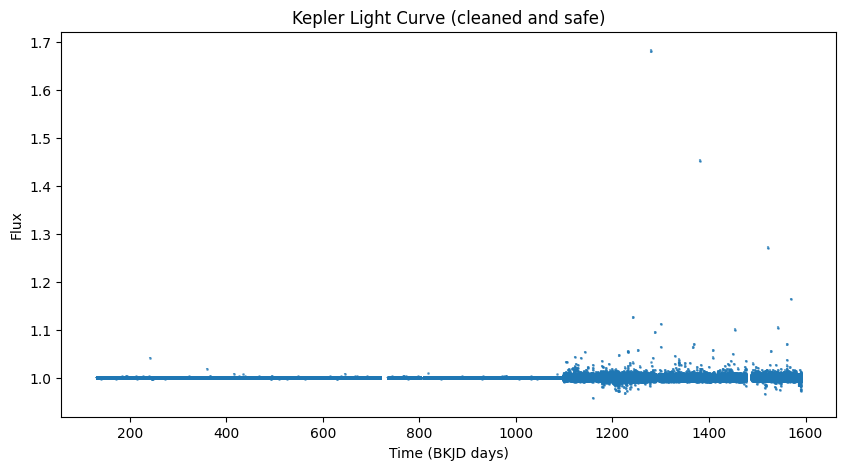

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.errorbar(time_clean, flux_clean, yerr=flux_err_clean, fmt='.', ms=2, alpha=0.6)
plt.xlabel("Time (BKJD days)")
plt.ylabel("Flux")
plt.title("Kepler Light Curve (cleaned and safe)")
plt.show()


In [24]:
print(data_ex['planets'])

['Kepler-226 c', 'Kepler-226 b', 'Kepler-226 d']
